# Verursacht Temu eine Erhöhung von Frachtflüfgen von China nach Europa? (Zweiter Datensatz)

Max Köhler/SWR DataLab (max.koehler@swr.de), 22. Oktober 2024 (Aktualisiert 29. Oktober 2024)


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from os import listdir
from os.path import isfile, join

In [2]:
# Proprietary flight data
file_dirs = ["./data/china-germany", "./data/china-belgium", "./data/china-netherlands"]
flights = pd.DataFrame()
for fd in file_dirs:
	filenames = [f for f in listdir(fd) if isfile(join(fd, f))]
	print(f"Reading {fd}: {len(filenames)} data files found")
	for fn in filenames:
		path = f"{fd}/{fn}"
		flights = pd.concat([flights, pd.read_csv(path, parse_dates=["date"], dtype={"flight_id": str})])


# Public domain airport data (https://ourairports.com/data/)
airports = pd.read_csv("./data/airports.csv")

Reading ./data/china-germany: 1 data files found
Reading ./data/china-belgium: 94 data files found
Reading ./data/china-netherlands: 94 data files found


In [3]:
# Drop airports without IATA codes
airports = airports.drop(
    airports[
        (airports["iata_code"].isnull())
     	| (airports["iata_code"] == "nan")
  	].index)

# Select landing events with destination IATA Codes
takeoffs = flights[
			(flights["destination_iata"].notnull())
    & (flights["event"] == "takeoff")
        ].drop_duplicates().reset_index(drop=True)

takeoffs["year_week"] = takeoffs["date"].apply(lambda x: f"{x.isocalendar()[0]}-{x.isocalendar()[1]}")
takeoffs["year_day"] = takeoffs["date"].dt.dayofyear

print(f"{takeoffs.shape[0]} takeoffs found.")
takeoffs

610506 takeoffs found.


,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time,year_week,year_day
0,3C4581,150,BOX303,2023-01-01,LEJ,EDDP,B77L,takeoff,3S303,783648915,26.27795,50.62120,BOX,BAH,OBBI,D-AALA,01:19:33,2022-52,1
1,A82AA0,150,UPS76,2023-01-01,SZX,ZGSZ,B748,takeoff,5X76,783653675,25.26376,55.35233,UPS,DXB,OMDB,N625UP,02:24:57,2022-52,1
2,3C542F,1675,BCS7JG,2023-01-01,LEJ,EDDP,A306,takeoff,NaN,783653718,40.49966,-3.57468,BCS,MAD,LEMD,D-AEAO,00:16:10,2022-52,1
3,06A081,2375,QTR8961,2023-01-01,ICN,RKSI,B77L,takeoff,QR8961,783654423,31.21332,121.81465,QTR,PVG,ZSPD,A7-BFC,00:09:12,2022-52,1
4,800CF5,125,SEJ7635,2023-01-01,KMG,ZPPP,B737,takeoff,SG7635,783656090,22.65907,88.44833,SEJ,CCU,VECC,VT-SFB,00:55:53,2022-52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610501,AC7364,75,FDX6335,2024-10-14,CDG,LFPG,B752,takeoff,FX6335,931889185,52.34711,4.71039,FDX,AMS,EHAM,N901FD,20:48:39,2024-42,288
610502,896356,5100,ETD957,2024-10-14,AMS,EHAM,B77L,takeoff,EY957,931892095,-1.32269,36.92292,ETD,NBO,HKJK,A6-DDB,20:56:16,2024-42,288
610503,4841C4,5100,MP8372,2024-10-14,AMS,EHAM,B744,takeoff,MP8372,931900085,-1.32297,36.92258,MPH,NBO,HKJK,PH-CKB,21:36:39,2024-42,288
610504,71BE17,150,KAL517,2024-10-14,AMS,EHAM,B748,takeoff,KE517,931912101,37.44635,126.43914,KAL,ICN,RKSI,HL7617,22:54:09,2024-42,288


In [4]:
# Merge airports on destination_iata
merged_flights = pd.merge(
	takeoffs,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["destination_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["destination_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

# Merge airports on origin_iata
merged_flights = pd.merge(
	merged_flights,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["origin_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["origin_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

missed_destination = merged_flights.loc[merged_flights["destination_country"].isnull()].shape[0]
missed_origin = merged_flights.loc[merged_flights["origin_country"].isnull()].shape[0]

print(f'Failed to set origin country for {missed_origin} flights ({round(missed_origin / takeoffs.shape[0] * 100, 2)}%) and destination country for {missed_destination} flights ({round(missed_destination / takeoffs.shape[0] * 100, 2)}%),\nlikely because their IATA codes are missing from our airport data.')

Failed to set origin country for 2922 flights (0.48%) and destination country for 1026 flights (0.17%),
likely because their IATA codes are missing from our airport data.


In [5]:
eu_countries = ("DE", "BE", "NL")

# Flights from any Chinese airport that landed in any Belgian, German, or Dutch airport
flights_china_eu = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))]

print(f"{flights_china_eu.shape[0]} flights from China to {eu_countries} found.")

9277 flights from China to ('DE', 'BE', 'NL') found.


## Ergebnisse

### Welche Daten liegen vor?

Die 189 vorliegenden CSV-Dateien enthalten Daten für weltweite, von FlightRadar24 erfasste Flüge im Zeitraum 01.01.2023-2024. Jeder Flug ist in einer Zeile repräsentiert einen Flug (es gibt Duplikate, aber diese werden in dieser Analyse bereits herausgefiltert). Insgesamt wurden 610.506 Flüge erfasst.

Zu jedem Flug werden eine Reihe von mehr oder weniger interessanten Metadaten angegeben. Die Spalte `event` enthält die Art des erfassten Flgereignisse. Anders als der erste Datensatz enthält vorliegende nur Ereignisse vom Typ `takeoff`. Die Spalten `origin_iata` und `destination_iata` sind Flughafen-Codes die wir relativ leicht Ländern oder Regionen zuordnen können (siehe oben). Lufthansa Cargo LH8403 von Shanghai Pudong International (`PVG`) nach Frankfurt (`FRA`) am 01.02.2023 ist zum Beispiel so repräsentiert:


In [6]:
merged_flights.loc[merged_flights["flight_id"] == "783802017"]

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,...,longitude,operator,origin_iata,origin_icao,registration,time,year_week,year_day,destination_country,origin_country
489,7805DC,4300,CKK211,2023-01-02,FRA,EDDF,B77L,takeoff,CK211,783802017,...,121.82915,CKK,PVG,ZSPD,B-2076,03:33:28,2023-1,2,DE,CN


### Kann man an den Daten erhöhten Flugverkehr durch Temu erkennen?

**Nein**. Aus der letzten Analyse wurde ersichtlich, dass "zwischen dem Start von Temu in 2023 und 2024 die Zahl der Flüge von China nach Europa um 36.3% gestiegen" ist. Mehr kann man aus den vorliegenden Daten auch nicht ablesen. Das Flugaufkommen fluktuiert, ein _Temu Spike_ ist nicht zu erkennen.


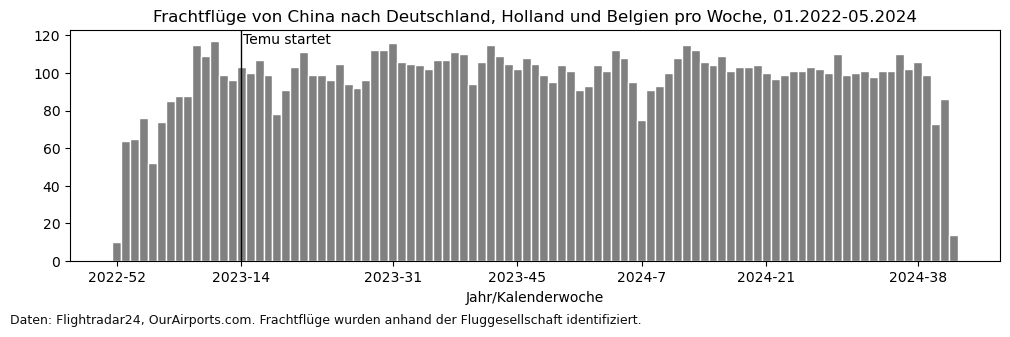

In [7]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

days = pd.DataFrame(pd.date_range(start='7/1/2019', end='10/1/2024', freq="W", name="date"))
months = pd.DataFrame(pd.date_range(start='7/1/2019', end='10/1/2024', freq="M", name="date"))

flights_per_period = pd.DataFrame(data=flights_china_eu.groupby(flights_china_eu.year_week).size(), columns=["count"]).reset_index()

# Some wrangling to bring the weekly counts back to chronological order
flights_per_period["year"] = flights_per_period["year_week"].str.split("-").apply(lambda x: int(x[0]))
flights_per_period["week"] = flights_per_period["year_week"].str.split("-").apply(lambda x: int(x[1]))
flights_per_period.sort_values(inplace=True,by=["year", "week"])

labels = pd.DataFrame([
	{"date": "2023-14", "text": "Temu startet", "y_offset": 0, "source": "https://www.reuters.com/technology/chinese-owned-e-commerce-platform-temu-expands-europe-2023-04-25/"},
])

fig,ax = plt.subplots(figsize=(12,3))
ax.set_title("Frachtflüge von China nach Deutschland, Holland und Belgien pro Woche, 01.2022-05.2024")
ax.bar(
  x=flights_per_period["year_week"],
  height=flights_per_period["count"],
	label="Anzahl Flüge",
	color="gray",
	width=1,
	edgecolor="white"
)
ax.xaxis.set_major_locator(locator)
ax.set_xlabel("Jahr/Kalenderwoche")
plt.xticks(rotation=0)
for index, l in labels.iterrows():
	ax.axvline(x=l["date"], color="black", lw=1, zorder=10)
	ax.annotate(
		zorder=200,
		text=l["text"],
		xy=(l["date"], 0),
		horizontalalignment="left",
		textcoords=("offset fontsize","axes fraction"),
		xytext=(.15,.94)
	)

ax.text(x=0.075, y=-0.1, s="Daten: Flightradar24, OurAirports.com. Frachtflüge wurden anhand der Fluggesellschaft identifiziert.", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()


### Gab es 2024 Routen/Verbindungen von China nach Europa, die es 2023 noch nicht gab?

**Nein**. Die Liste der angeflogenen Flughäfen in Deutschland, Belgien und den Niederlanden bleibt in den vorliegenden Daten zwischen 2023 und 2024 unverändert.


In [8]:
china_eu_23 = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2023)]

china_eu_24 = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2024)]

destinations_23 = pd.Series(sorted(pd.unique(china_eu_23["destination_iata"])))
destinations_24 = pd.Series(sorted(pd.unique(china_eu_24["destination_iata"])))

print(f"Equals: {destinations_23.equals(destinations_24)}")

Equals: True


### Wie hat sich die Zahl von Frachtflügen/Woche an den angegebenen Flughäfen zwischen 2023 und 2024 entwickelt?

- Die Zahl von Frachtflügen ist insgesamt um 3,42% gestiegen, von durchschnittlich 95,30 Flügen/Woche auf 98,57 Flüge/Woche
- Den stärksten Anstieg gab es in In Köln/Bonn: 3,6 Flüge/Woche auf 4,6 Flüge/Woche, ein Anstieg von 31.1%.
- In Frankfurt, Amsterdam und Brüssel ist die Zahl der Frachtflüge gefallen.

| IATA | Name                       | Flüge/Woche 2023 | Flüge/Woche 2024 | Veränderung |
| ---- | -------------------------- | ---------------- | ---------------- | ----------- |
| LGG  | Liège Airport              | 18.595238        | 19.785714        | +6,40%      |
| AMS  | Amsterdam Airport Schiphol | 30.904762        | 30.476190        | -1,39%      |
| FRA  | Frankfurt Airport          | 31.642857        | 29.952381        | -5,34%      |
| BRU  | Brussels Airport           | 3.100000         | 2.444444         | -21,15%     |
| CGN  | Cologne Bonn Airport       | 3.540541         | 4.642857         | +31,13%     |
| LEJ  | Leipzig/Halle Airport      | 12.027778        | 13.190476        | +9,67%      |
|      | All EU Airports            | 95.309524        | 98.571429        | +3,42%      |

Weil noch nicht alle Daten für 2024 vorliegen wurden für beide Jahre nur die ersten 288 Tage berücksichtigt.


In [10]:
# We only want to look at 2023 up to the date where our 2024 data ends
cutoff = china_eu_24["year_day"].max()

years = [2023,2024]
ap = pd.unique(china_eu_23["destination_iata"])
results = pd.DataFrame(columns=["iata", "name"])

# Calculate flights/per week per European airport
for iata in ap:
	result = pd.DataFrame({"iata": [iata], "name": airports.loc[airports["iata_code"] == iata]["name"].values})
	for y in years:
		flights_year = merged_flights.loc[
			(merged_flights["origin_country"] == "CN")
    	& (merged_flights["destination_iata"] == iata)
    	& (merged_flights["date"].dt.year == y)
    	& (merged_flights["year_day"] <= cutoff)
		]
		fpw = pd.DataFrame(data=flights_year.groupby(flights_year.year_week).size(), columns=["count"]).reset_index()
		result[f"fpw_{y}"] = fpw["count"].mean()
	results = pd.concat([results, result], ignore_index=True)


# Calculate flights/per week across all EU airports
china_eu_23 = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2023)
    & (merged_flights["year_day"] <= cutoff)]

china_eu_24 = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2024)]

fpw_23 = pd.DataFrame(data=china_eu_23.groupby(china_eu_23.year_week).size(), columns=["count"]).reset_index()
fpw_24 = pd.DataFrame(data=china_eu_24.groupby(china_eu_24.year_week).size(), columns=["count"]).reset_index()

res = pd.DataFrame({
	"name": ["All EU Airports"],
	"fpw_2023": [fpw_23["count"].mean()],
	"fpw_2024": [fpw_24["count"].mean()]
	})

results = pd.concat([results, res], ignore_index=True)
results["change"] = results["fpw_2024"].divide(results["fpw_2023"]) - 1
print(f"Cutoff day: {cutoff}")
print(results)
print("results")

Cutoff day: 288
  iata                        name   fpw_2023   fpw_2024    change
0  LGG               Liège Airport  18.595238  19.785714  0.064020
1  AMS  Amsterdam Airport Schiphol  30.904762  30.476190 -0.013867
2  FRA           Frankfurt Airport  31.642857  29.952381 -0.053424
3  BRU            Brussels Airport   3.100000   2.444444 -0.211470
4  CGN        Cologne Bonn Airport   3.540541   4.642857  0.311341
5  LEJ       Leipzig/Halle Airport  12.027778  13.190476  0.096668
6  NaN             All EU Airports  95.309524  98.571429  0.034224
results
